/var/folders/hh/yly126sx0nv7wh7rwnh8n_pm0000gn/T/ipykernel_28026/2867132424.py:145: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout(rect=[0.04, 0.12, 0.96, 0.76])


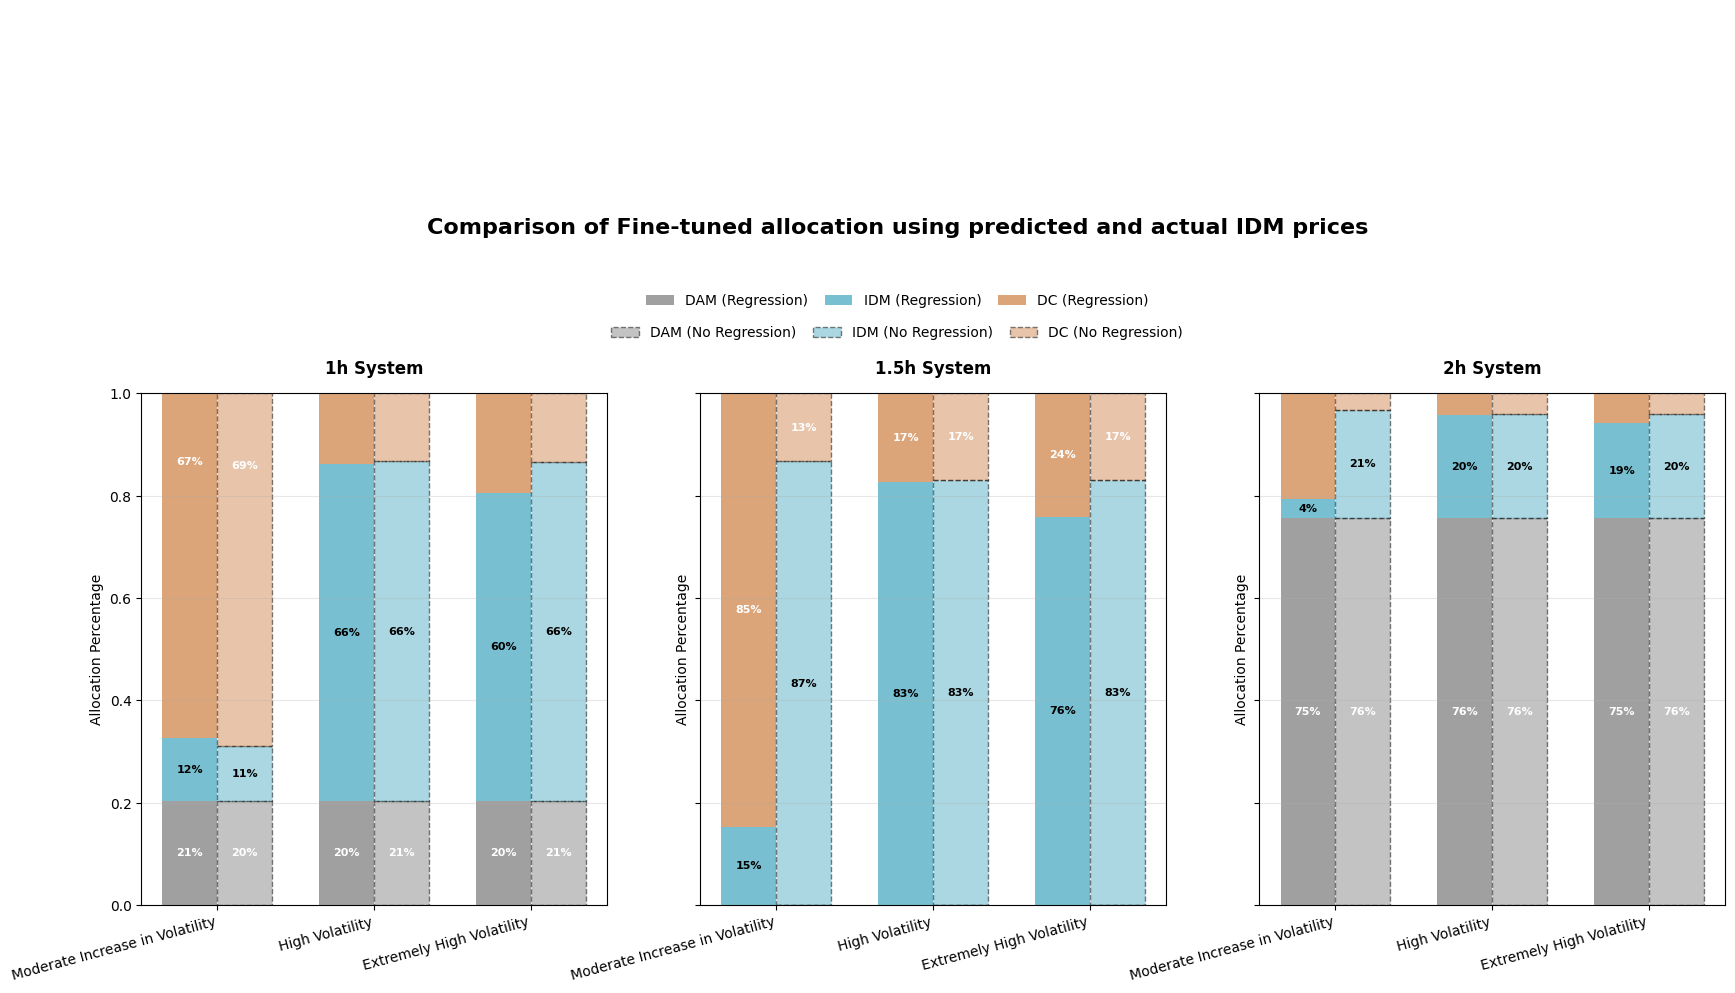

In [9]:
'''Figure 35 - Comparison of Fine-tuned Allocation (Predicted vs Actual IDM Prices)'''
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# ============ Utilities ============

def round_percentages(values):
    """Round proportions to integer % that sum to 100 using largest remainders method."""
    vals = np.asarray(values, dtype=float)
    if np.isnan(vals).any() or vals.sum() == 0:
        return None
    
    pct = vals * 100.0
    floored = np.floor(pct).astype(int)
    remainder = pct - floored
    diff = int(round(100 - floored.sum()))
    
    if diff > 0:
        idx = np.argsort(-remainder)[:diff]
        floored[idx] += 1
    elif diff < 0:
        idx = np.argsort(remainder)[:abs(diff)]
        floored[idx] -= 1
    
    return floored.tolist()

def annotate_stack(ax, x, parts, bar_width, side='left', show_thresholds=(5, 2, 2),
                   text_kw=None, colors=('white', 'black', 'white')):
    """Add percentage labels centered on each stacked segment."""
    text_kw = text_kw or dict(fontsize=8, fontweight='bold', ha='center', va='center')
    offset = -bar_width/2 if side == 'left' else bar_width/2
    rounded = round_percentages(parts)
    
    if rounded is None:
        return
    
    bottoms = np.cumsum([0, parts[0], parts[0] + parts[1]])
    centers = bottoms + np.array(parts) / 2.0
    
    for idx, (pct, y, thr, col) in enumerate(zip(rounded, centers, show_thresholds, colors)):
        if pct >= thr and parts[idx] > 0:
            ax.text(x + offset, y, f'{pct}%', color=col, **text_kw)

# ============ Data Loading ============

# Load and prepare regression data (filtered for risk_aversion=3)
data_reg_full = pd.read_csv('/Users/haixiaosun/Library/Mobile Documents/com~apple~CloudDocs/Coding Work/Markowitz exploration/Figure_12_Model_Outputs/figure_12_2024.csv')
data_reg_full['Duration'] = data_reg_full['energy_mwh'] / data_reg_full['power_mw']
data_regression = data_reg_full[data_reg_full['risk_aversion'] == 3.0].copy()

# Load no-regression data and calculate Duration
data_no_regression = pd.read_csv('/Users/haixiaosun/Library/Mobile Documents/com~apple~CloudDocs/Coding Work/Markowitz exploration/Fig_35_Model_Outputs/fig_35_no_regression_results.csv')
data_no_regression['Duration'] = data_no_regression['energy_mwh'] / data_no_regression['power_mw']

# Configuration
scenarios = ['2023', '2021', '2022']
scenario_labels = ['Moderate Increase in Volatility', 'High Volatility', 'Extremely High Volatility']
durations = [1.0, 1.5, 2.0]
duration_labels = ['1h System', '1.5h System', '2h System']
colors = {'DAM': '#888888', 'IDM': '#56b1c6c7', 'DC': '#d38d5763'}

def get_allocation(df, duration, scenario):
    """Extract [DAM, IDM, DC] allocation proportions."""
    sub = df[df['Duration'] == duration]
    dam = sub['baseline_dam_weight'].mean()
    remaining = max(0.0, 1.0 - dam)
    idm = sub[f'updated_{scenario}_idm_weight'].mean() * remaining
    dc = sub[f'updated_{scenario}_dc_weight'].mean() * remaining
    return [dam, idm, dc]

# ============ Plotting ============

fig, axes = plt.subplots(1, 3, figsize=(18, 8), sharey=True)

bar_width = 0.35
x_pos = np.arange(len(scenarios))

for ax, duration, title in zip(axes, durations, duration_labels):
    # Get data
    reg_data = np.array([get_allocation(data_regression, duration, s) for s in scenarios])
    nor_data = np.array([get_allocation(data_no_regression, duration, s) for s in scenarios])
    
    # Stacked bars — Regression (left stack)
    ax.bar(x_pos - bar_width/2, reg_data[:, 0], bar_width, label='DAM (Regression)',
           color=colors['DAM'], alpha=0.8)
    ax.bar(x_pos - bar_width/2, reg_data[:, 1], bar_width, bottom=reg_data[:, 0],
           label='IDM (Regression)', color=colors['IDM'], alpha=0.8)
    ax.bar(x_pos - bar_width/2, reg_data[:, 2], bar_width, bottom=reg_data[:, 0] + reg_data[:, 1],
           label='DC (Regression)', color=colors['DC'], alpha=0.8)

    # Stacked bars — No Regression (right stack)
    ax.bar(x_pos + bar_width/2, nor_data[:, 0], bar_width, label='DAM (No Regression)',
           color=colors['DAM'], alpha=0.5, edgecolor='black', linewidth=1, linestyle='--')
    ax.bar(x_pos + bar_width/2, nor_data[:, 1], bar_width, bottom=nor_data[:, 0],
           label='IDM (No Regression)', color=colors['IDM'], alpha=0.5,
           edgecolor='black', linewidth=1, linestyle='--')
    ax.bar(x_pos + bar_width/2, nor_data[:, 2], bar_width, bottom=nor_data[:, 0] + nor_data[:, 1],
           label='DC (No Regression)', color=colors['DC'], alpha=0.5,
           edgecolor='black', linewidth=1, linestyle='--')

    # Format subplot
    ax.set_title(title, fontweight='bold', pad=14)
    ax.set_ylabel('Allocation Percentage')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(scenario_labels, rotation=15, ha='right')
    ax.set_ylim(0, 1)
    ax.grid(True, alpha=0.3, axis='y')

    # Add percentage labels
    for i in range(len(scenarios)):
        annotate_stack(ax, i, reg_data[i], bar_width, side='left',
                       show_thresholds=(5, 2, 2), colors=('white', 'black', 'white'))
        annotate_stack(ax, i, nor_data[i], bar_width, side='right',
                       show_thresholds=(5, 2, 2), colors=('white', 'black', 'white'))

# ============ Legends & Layout ============

fig.suptitle('Comparison of Fine-tuned allocation using predicted and actual IDM prices',
             fontsize=16, fontweight='bold', y=0.98)

# Get handles/labels once from the first axes
handles, labels = axes[0].get_legend_handles_labels()

# Split into the two groups in the order they were added
regression_handles = handles[:3]
no_regression_handles = handles[3:]

regression_labels = ['DAM (Regression)', 'IDM (Regression)', 'DC (Regression)']
no_regression_labels = ['DAM (No Regression)', 'IDM (No Regression)', 'DC (No Regression)']

# Two centered legends (row 1: Regression, row 2: No Regression)
fig.legend(regression_handles, regression_labels,
           loc='upper center', bbox_to_anchor=(0.5, 0.90),
           ncol=3, frameon=False, columnspacing=1.2, handlelength=2.0)

fig.legend(no_regression_handles, no_regression_labels,
           loc='upper center', bbox_to_anchor=(0.5, 0.86),
           ncol=3, frameon=False, columnspacing=1.2, handlelength=2.0)

# Reserve vertical space for the legends & title
plt.subplots_adjust(top=0.76, bottom=0.12, left=0.08, right=0.96)

# Tighten the subplot area only (exclude the legend/title band)
plt.tight_layout(rect=[0.04, 0.12, 0.96, 0.76])

plt.show()

/var/folders/hh/yly126sx0nv7wh7rwnh8n_pm0000gn/T/ipykernel_28026/2867132424.py:145: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout(rect=[0.04, 0.12, 0.96, 0.76])


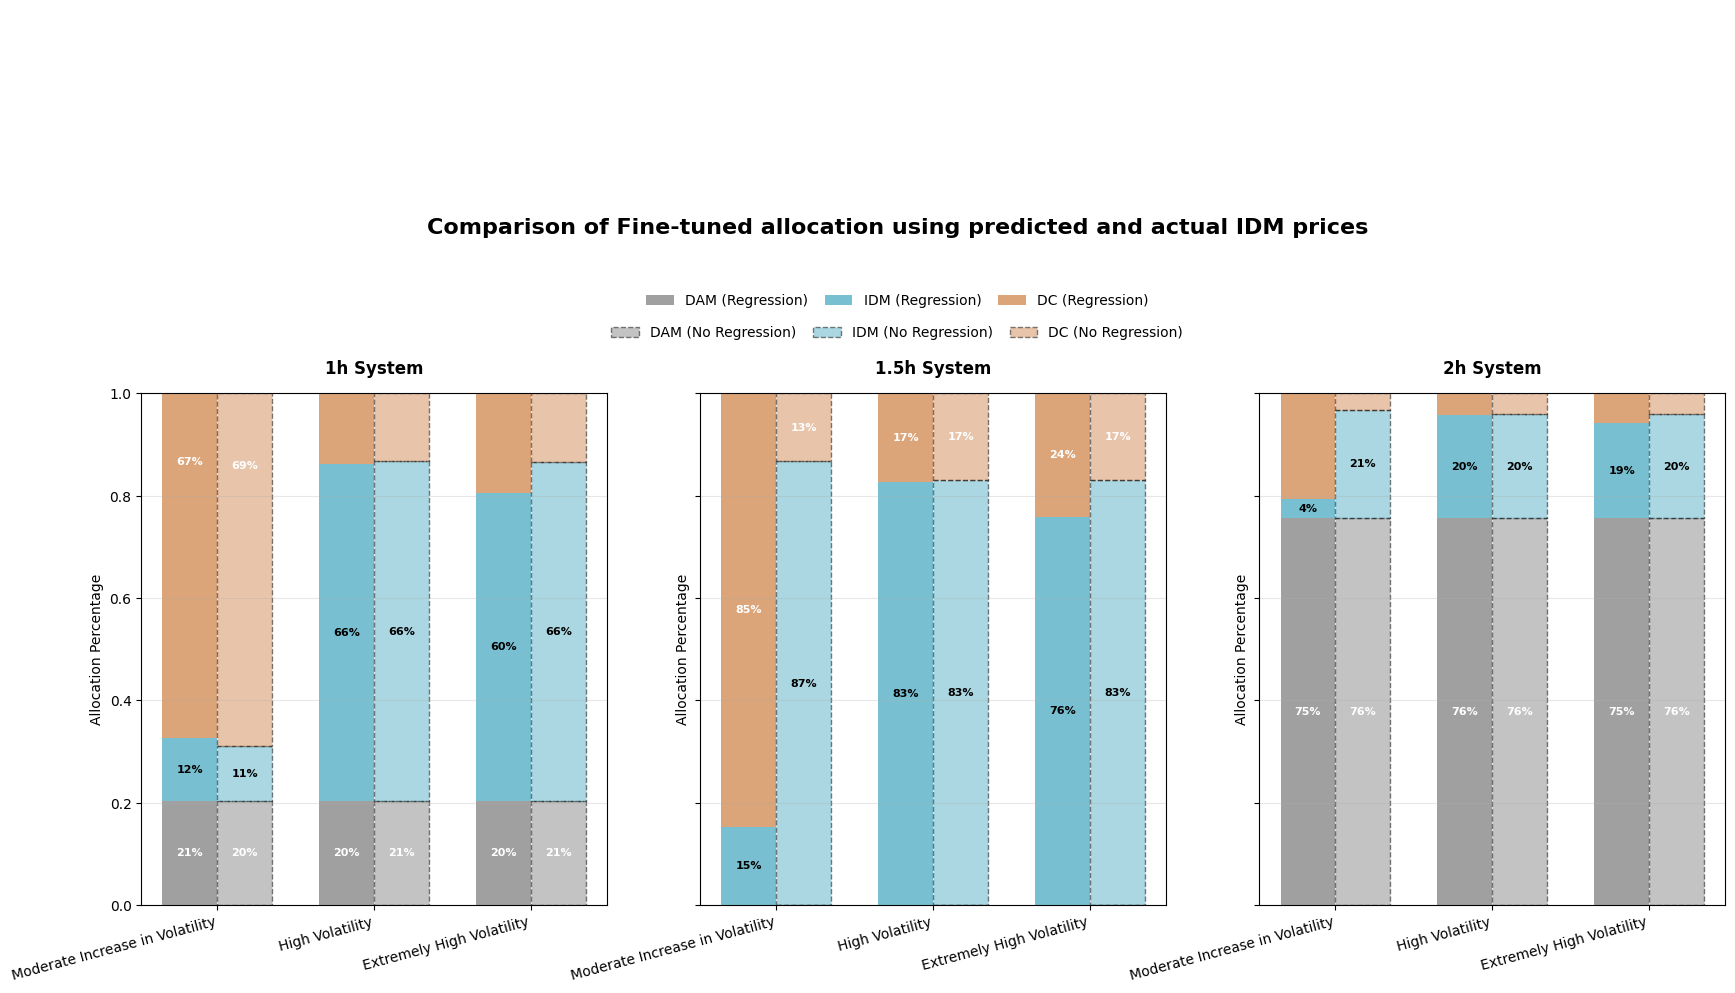

In [10]:
'''Figure 35 - Comparison of Fine-tuned Allocation (Predicted vs Actual IDM Prices)'''
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# ============ Utilities ============

def round_percentages(values):
    """Round proportions to integer % that sum to 100 using largest remainders method."""
    vals = np.asarray(values, dtype=float)
    if np.isnan(vals).any() or vals.sum() == 0:
        return None
    
    pct = vals * 100.0
    floored = np.floor(pct).astype(int)
    remainder = pct - floored
    diff = int(round(100 - floored.sum()))
    
    if diff > 0:
        idx = np.argsort(-remainder)[:diff]
        floored[idx] += 1
    elif diff < 0:
        idx = np.argsort(remainder)[:abs(diff)]
        floored[idx] -= 1
    
    return floored.tolist()

def annotate_stack(ax, x, parts, bar_width, side='left', show_thresholds=(5, 2, 2),
                   text_kw=None, colors=('white', 'black', 'white')):
    """Add percentage labels centered on each stacked segment."""
    text_kw = text_kw or dict(fontsize=8, fontweight='bold', ha='center', va='center')
    offset = -bar_width/2 if side == 'left' else bar_width/2
    rounded = round_percentages(parts)
    
    if rounded is None:
        return
    
    bottoms = np.cumsum([0, parts[0], parts[0] + parts[1]])
    centers = bottoms + np.array(parts) / 2.0
    
    for idx, (pct, y, thr, col) in enumerate(zip(rounded, centers, show_thresholds, colors)):
        if pct >= thr and parts[idx] > 0:
            ax.text(x + offset, y, f'{pct}%', color=col, **text_kw)

# ============ Data Loading ============

# Load and prepare regression data (filtered for risk_aversion=3)
data_reg_full = pd.read_csv('/Users/haixiaosun/Library/Mobile Documents/com~apple~CloudDocs/Coding Work/Markowitz exploration/Figure_12_Model_Outputs/figure_12_2024.csv')
data_reg_full['Duration'] = data_reg_full['energy_mwh'] / data_reg_full['power_mw']
data_regression = data_reg_full[data_reg_full['risk_aversion'] == 3.0].copy()

# Load no-regression data and calculate Duration
data_no_regression = pd.read_csv('/Users/haixiaosun/Library/Mobile Documents/com~apple~CloudDocs/Coding Work/Markowitz exploration/Fig_35_Model_Outputs/fig_35_no_regression_results.csv')
data_no_regression['Duration'] = data_no_regression['energy_mwh'] / data_no_regression['power_mw']

# Configuration
scenarios = ['2023', '2021', '2022']
scenario_labels = ['Moderate Increase in Volatility', 'High Volatility', 'Extremely High Volatility']
durations = [1.0, 1.5, 2.0]
duration_labels = ['1h System', '1.5h System', '2h System']
colors = {'DAM': '#888888', 'IDM': '#56b1c6c7', 'DC': '#d38d5763'}

def get_allocation(df, duration, scenario):
    """Extract [DAM, IDM, DC] allocation proportions."""
    sub = df[df['Duration'] == duration]
    dam = sub['baseline_dam_weight'].mean()
    remaining = max(0.0, 1.0 - dam)
    idm = sub[f'updated_{scenario}_idm_weight'].mean() * remaining
    dc = sub[f'updated_{scenario}_dc_weight'].mean() * remaining
    return [dam, idm, dc]

# ============ Plotting ============

fig, axes = plt.subplots(1, 3, figsize=(18, 8), sharey=True)

bar_width = 0.35
x_pos = np.arange(len(scenarios))

for ax, duration, title in zip(axes, durations, duration_labels):
    # Get data
    reg_data = np.array([get_allocation(data_regression, duration, s) for s in scenarios])
    nor_data = np.array([get_allocation(data_no_regression, duration, s) for s in scenarios])
    
    # Stacked bars — Regression (left stack)
    ax.bar(x_pos - bar_width/2, reg_data[:, 0], bar_width, label='DAM (Regression)',
           color=colors['DAM'], alpha=0.8)
    ax.bar(x_pos - bar_width/2, reg_data[:, 1], bar_width, bottom=reg_data[:, 0],
           label='IDM (Regression)', color=colors['IDM'], alpha=0.8)
    ax.bar(x_pos - bar_width/2, reg_data[:, 2], bar_width, bottom=reg_data[:, 0] + reg_data[:, 1],
           label='DC (Regression)', color=colors['DC'], alpha=0.8)

    # Stacked bars — No Regression (right stack)
    ax.bar(x_pos + bar_width/2, nor_data[:, 0], bar_width, label='DAM (No Regression)',
           color=colors['DAM'], alpha=0.5, edgecolor='black', linewidth=1, linestyle='--')
    ax.bar(x_pos + bar_width/2, nor_data[:, 1], bar_width, bottom=nor_data[:, 0],
           label='IDM (No Regression)', color=colors['IDM'], alpha=0.5,
           edgecolor='black', linewidth=1, linestyle='--')
    ax.bar(x_pos + bar_width/2, nor_data[:, 2], bar_width, bottom=nor_data[:, 0] + nor_data[:, 1],
           label='DC (No Regression)', color=colors['DC'], alpha=0.5,
           edgecolor='black', linewidth=1, linestyle='--')

    # Format subplot
    ax.set_title(title, fontweight='bold', pad=14)
    ax.set_ylabel('Allocation Percentage')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(scenario_labels, rotation=15, ha='right')
    ax.set_ylim(0, 1)
    ax.grid(True, alpha=0.3, axis='y')

    # Add percentage labels
    for i in range(len(scenarios)):
        annotate_stack(ax, i, reg_data[i], bar_width, side='left',
                       show_thresholds=(5, 2, 2), colors=('white', 'black', 'white'))
        annotate_stack(ax, i, nor_data[i], bar_width, side='right',
                       show_thresholds=(5, 2, 2), colors=('white', 'black', 'white'))

# ============ Legends & Layout ============

fig.suptitle('Comparison of Fine-tuned allocation using predicted and actual IDM prices',
             fontsize=16, fontweight='bold', y=0.98)

# Get handles/labels once from the first axes
handles, labels = axes[0].get_legend_handles_labels()

# Split into the two groups in the order they were added
regression_handles = handles[:3]
no_regression_handles = handles[3:]

regression_labels = ['DAM (Regression)', 'IDM (Regression)', 'DC (Regression)']
no_regression_labels = ['DAM (No Regression)', 'IDM (No Regression)', 'DC (No Regression)']

# Two centered legends (row 1: Regression, row 2: No Regression)
fig.legend(regression_handles, regression_labels,
           loc='upper center', bbox_to_anchor=(0.5, 0.90),
           ncol=3, frameon=False, columnspacing=1.2, handlelength=2.0)

fig.legend(no_regression_handles, no_regression_labels,
           loc='upper center', bbox_to_anchor=(0.5, 0.86),
           ncol=3, frameon=False, columnspacing=1.2, handlelength=2.0)

# Reserve vertical space for the legends & title
plt.subplots_adjust(top=0.76, bottom=0.12, left=0.08, right=0.96)

# Tighten the subplot area only (exclude the legend/title band)
plt.tight_layout(rect=[0.04, 0.12, 0.96, 0.76])

plt.show()